In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from time import time
import pandas as pd
import seaborn as sns
import argparse
from scipy import signal
import skfuzzy as fuzz
from skimage.exposure import rescale_intensity

In [2]:
## Configure some general styling
sns.set_style("white")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = (8,7)
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

In [3]:
def show_plane(ax, plane, cmap="viridis", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)
        
    # Define the necessary functions
def getTheFile(filename,rows,cols,start,stop):
    from denpy import DEN
    arr = np.empty([rows, cols, 0])    
    for i in range(start,stop,1):
        Frame = DEN.getFrame(filename, i, row_from=None, row_to=None, col_from=None, col_to=None)
        dentoarr = np.asarray(Frame)
        dentoarr = np.expand_dims(dentoarr, axis=2)
        arr = np.concatenate((arr, dentoarr), axis=2)
    return arr

# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

In [4]:
#Getting the 3D-array and 2D-TestingFrame for CT 
print("File is loading ")
Carm_ICA = getTheFile("KVA_carm.den",550,550,173,192)
print("File is loaded with the shape: ",Carm_ICA.shape)
#Normalize the data  
print("Normalizing the data") 
normalized = (Carm_ICA-Carm_ICA.min())/(Carm_ICA.max()-Carm_ICA.min())

File is loading 
File is loaded with the shape:  (550, 550, 19)
Normalizing the data


In [5]:
original_shape = normalized.shape

In [6]:
from sklearn.cluster import KMeans
reshaped  = normalized.reshape(-1,1)
print (reshaped.shape)
# Using Kmeans to separate foreground (soft tissue / bone) and background (air)
kmeans = KMeans(n_clusters=3).fit(reshaped)
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)

(5747500, 1)


In [ ]:
ICA = kmeans.labels_.reshape(original_shape[0],original_shape[1],original_shape[2])

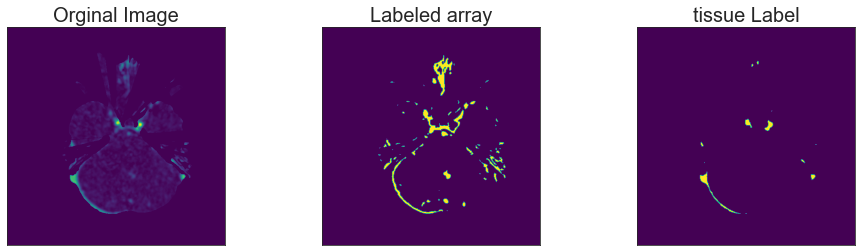

In [9]:
_, (a, b,c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, ICA[:,:,1]==1, title="Labeled array", cmap="viridis")
show_plane(c, ICA[:,:,1]==2, title="tissue Label", cmap="viridis")

In [10]:
def MyCC3d(labeledarr,originalarr):
    import cc3d
    from skimage import segmentation,measure,morphology
    print("computing cc3d")
    labels_out = cc3d.connected_components(labeledarr)
    print("removing small size objects to decrease the output labels")
    interior_labels = morphology.remove_small_objects(labels_out, min_size=300)
    print("relabelling")
    relabeled, _, _ = segmentation.relabel_sequential(interior_labels)
    print("computing the objects properties")
    regionprops = measure.regionprops(relabeled, intensity_image=originalarr)
    print("Computing the areas")
    areas = [regionprop.area for regionprop in regionprops]
    return relabeled,regionprops,areas

def computeAvgDraw(frames):
    print("calculating the average from each frame")
    yvalues =[]
    xvalues = range(frames.shape[2])
    for i in range(frames.shape[2]):
        avg = np.average(frames[:,:,i]!= 0)
        yvalues.append(avg)
    
    print("Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve")
    return xvalues,yvalues

In [11]:
relabeled,regionprops,areas = MyCC3d(ICA,Carm_ICA)

computing cc3d
removing small size objects to decrease the output labels
relabelling
computing the objects properties
Computing the areas


In [12]:
print("labels: {}".format(np.unique(relabeled[:,:,1])))
for i in range(len(np.unique(relabeled[:,:,1]))):
    print("area: {}".format(areas[i]))

labels: [ 0  1  3  8  9 11 12 13 15 16 20 22 23 24 25 26]
area: 26182
area: 463
area: 367
area: 420
area: 472
area: 872
area: 317
area: 553
area: 59421
area: 575
area: 9407
area: 5185
area: 57429
area: 358
area: 328
area: 547


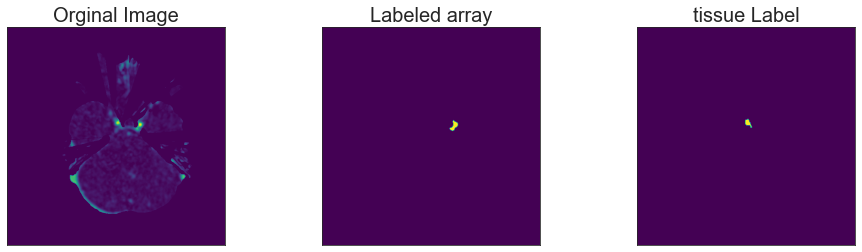

In [13]:
_, (a, b,c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, relabeled[:,:,1]==11, title="Labeled array", cmap="viridis")
show_plane(c, relabeled[:,:,1]==12, title="tissue Label", cmap="viridis")

In [14]:
L_ICA_mask = relabeled==11
L_ICA = Carm_ICA * L_ICA_mask
R_ICA_mask = relabeled==12
R_ICA = Carm_ICA * R_ICA_mask

In [15]:
 xvalues_L, yvalues_L = computeAvgDraw(L_ICA)
 xvalues_R, yvalues_R = computeAvgDraw(R_ICA)

calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve
calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve


Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


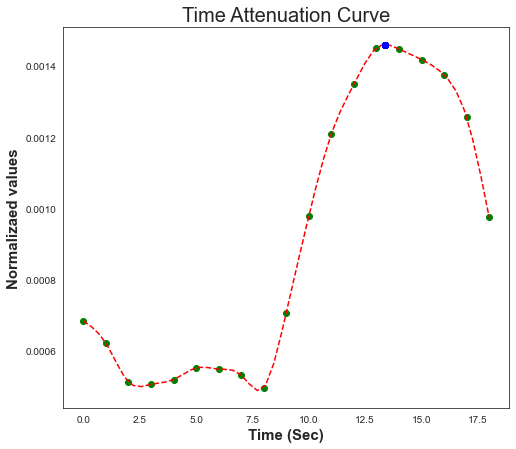

Maximum concentration = 0.0014603703922
Time to peak = 13.384645825
area = 0.044455629171325


In [16]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
p=GEKKO()
#Parameter
xspline = p.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
yspline = p.Var()
p.cspline(xspline,yspline,xvalues,yvalues_R)
pxx=p.Var(value=1 ,lb=10,ub=16)
pyy=p.Var()
p.Obj(-pyy)
p.cspline(pxx,pyy,xvalues,yvalues_R)
#Regression Mode
p.options.IMODE = 2
#Optimize
p.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_R,'go',label='data')
plt.plot(xspline,yspline,'r--',label='cubic spline')
plt.plot(pxx,pyy,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(pyy.VALUE[1]))
print("Time to peak =", str(pxx.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(yspline)
print("area =", area)

Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


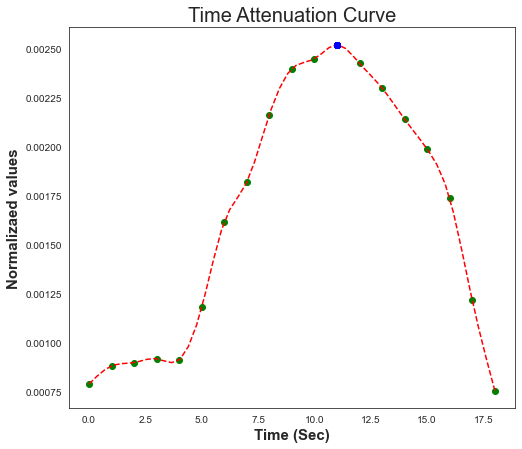

Maximum concentration = 0.002519031896
Time to peak = 10.997718098
area = 0.08265461717900001


In [17]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
m=GEKKO()
#Parameter
mxspline = m.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
myspline = m.Var()
m.cspline(mxspline,myspline,xvalues,yvalues_L)
px=m.Var(value=1 ,lb=10,ub=16)
py=m.Var()
m.Obj(-py)
m.cspline(px,py,xvalues,yvalues_L)
#Regression Mode
m.options.IMODE = 2
#Optimize
m.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_L,'go',label='data')
plt.plot(mxspline,myspline,'r--',label='cubic spline')
plt.plot(px,py,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(py.VALUE[1]))
print("Time to peak =", str(px.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(myspline)
print("area =", area)

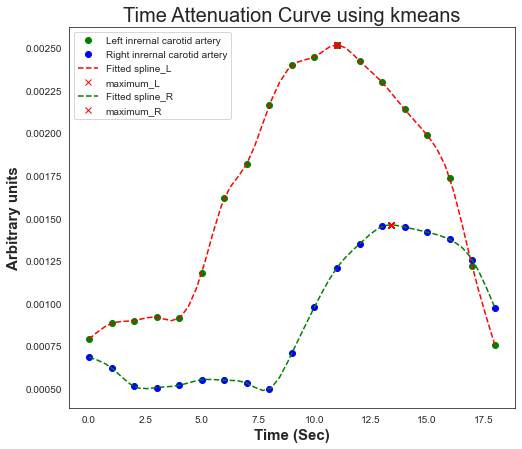

In [18]:
fig2 = plt.gcf()
plt.title('Time Attenuation Curve using kmeans')

plt.plot(xvalues,yvalues_L,'go',label='Left inrernal carotid artery')
plt.plot(xvalues,yvalues_R,'bo',label='Right inrernal carotid artery')
plt.plot(mxspline,myspline,'r--',label='Fitted spline_L')
plt.plot(px,py,'rx',label='maximum_L')


plt.plot(xspline,yspline,'g--',label='Fitted spline_R')
plt.plot(pxx,pyy,'rx',label='maximum_R')
plt.ylabel('Arbitrary units')
plt.xlabel('Time (Sec)')
plt.legend()